# 02: Simple interference with vgg16

Deep Learning at different levels:

- Define a network, train it and use it
- Use the structure of a network, train and use it
- Use a pre-trained network, refine its training and use it
- Finally, simply use a pre-trained network as a black box

In [1]:
# set path containing data folder or use default for Colab (/gdrive/My Drive)
local_folder = ".../"
import urllib.request
urllib.request.urlretrieve('https://raw.githubusercontent.com/guiwitz/DLImaging/master/utils/check_colab.py', 'check_colab.py')
from check_colab import set_datapath
colab, datapath = set_datapath(local_folder)

### Loading a pre-trained network from PyTorch

- PyTorch has several packages to deal with specific needs of DL
- TorchVision deals with image-related topics
- TorchVision provides popular pre-trained networks, standard datasets as well as functions specifically designed for images that one can integrate into a network.

In [2]:
# import VGG16 network with pretrained weights

import torchvision.models as models
import torch
import numpy as np 


In [3]:
vgg16 = models.vgg16(pretrained=True)

/home/jaz/mambaforge/envs/DLImaging/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jaz/mambaforge/envs/DLImaging/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
import skimage
import matplotlib.pyplot as plt

In [7]:
image = skimage.io.imread(datapath.joinpath('data/woody_allonge.jpg'))

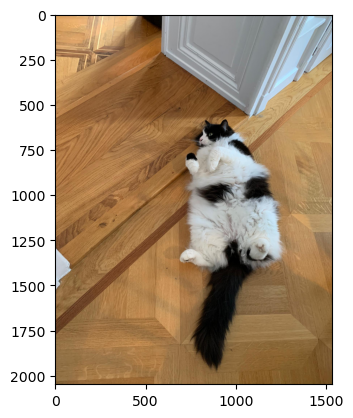

In [9]:
plt.imshow(image)

In [11]:
# pre-processing of image to fit network/calculation

def preprocess(image):
    image = skimage.transform.rescale(image, 0.2, channel_axis=2)
    image_normalised = (image-np.array([0.485, 0.456, 0.406]))/np.array([[0.229, 0.224, 0.225]])
    image_tensor = torch.tensor(image_normalised, dtype=torch.float32)
    image_tensor = image_tensor.permute(2,0,1)
    image_tensor = image_tensor.unsqueeze(0)

    return image_tensor

In [12]:
image_tensor = preprocess(image)

In [14]:
# set network to evaluate state and pass our image through it:

vgg16.eval()
result = vgg16(image_tensor)
result.shape

torch.Size([1, 1000])

- Result is a 1000 elements long vector.
- Each element represents the probability of the corresponding class
- Here have list of indices, but want to match it to the list of 1000 features of the *Imagenet dataset*
- Download the list and make a dictionary:

In [16]:
import requests
url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
data = requests.get(url).json()
label_dict = {x: data[x] for x in range (len(data))}

In [18]:
# sort indices and filter 10 largest ones

values, indices = torch.sort(result, descending=True)
indices_numpy = indices.numpy()

In [19]:
for i in range(10):
    print(label_dict[indices_numpy[0,i]])

collie
Border Collie
doormat
skunk
Old English Sheepdog
Persian cat
Shetland Sheepdog
Cardigan Welsh Corgi
tabby cat
Alaskan Malamute


The ImageNet dataset is very large and contains many categories. We see that depending on the picture, the network can easily be fooled into thinking that we deal with a dog or even a doormat! However it consistently identifies the presence of an animal in the picture, so we could imagine that re-trained on a narrower set of categories, the network would be very efficient. In fact we will see later that we can even re-use the pre-trained network and fine-tune it for narrower questions. Still it is remarkable that in few lines of code we can exploit such complex software!